**1. Import Packages and relevant files**

In [24]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_csv('/content/drive/MyDrive/hdb-price-with-features-2014to2023.csv')
cpi = pd.read_csv('/content/drive/MyDrive/CPI 2004 to 2023.csv')

df['month'] = pd.to_datetime(df['month'], format='%m/%d/%Y')
df['year'] = df['month'].dt.year

cpi['month'] = pd.to_datetime(cpi['month'], format='%m/%d/%Y')

In [3]:
df.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,distance_to_cbd_km,matured,year
0,0,2023-03-01,BISHAN,4 ROOM,289,BISHAN ST 24,22 TO 24,103.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2023
1,1,2022-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,22 TO 24,102.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022
2,2,2022-11-01,BISHAN,4 ROOM,289,BISHAN ST 24,16 TO 18,102.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022
3,3,2022-06-01,BISHAN,5 ROOM,289,BISHAN ST 24,07 TO 09,121.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022
4,4,2021-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,102.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2021


In [4]:
cpi.head()

,month,CPI
0,2004-01-01,75.741
1,2004-02-01,76.613
2,2004-03-01,76.051
3,2004-04-01,76.564
4,2004-05-01,76.747


**2. Normalize Price with CPI (Base Year 2019)**

In [5]:
df = df.drop(df.columns[0], axis=1)
df = pd.merge(df, cpi, on='month',how ='left')
df['normalized_price'] = (df['resale_price'] / df['CPI'].fillna(100))*100

df = df.drop(['resale_price'], axis=1)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,distance_to_cbd_km,matured,year,CPI,normalized_price
0,2023-03-01,BISHAN,4 ROOM,289,BISHAN ST 24,22 TO 24,103.0,Premium Apartment,1998,74.333333,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2023,NaN,750388.000000
1,2022-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,22 TO 24,102.0,Premium Apartment,1998,74.583333,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022,111.186,764484.737287
2,2022-11-01,BISHAN,4 ROOM,289,BISHAN ST 24,16 TO 18,102.0,Premium Apartment,1998,74.666667,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022,110.959,683135.212105
3,2022-06-01,BISHAN,5 ROOM,289,BISHAN ST 24,07 TO 09,121.0,Premium Apartment,1998,75.083333,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022,108.671,809783.658934
4,2021-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,102.0,Premium Apartment,1998,75.583333,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2021,104.439,579285.515947


**3. Feature Selection/Engineering**

In [6]:
df = df.drop(['block', 'street_name', 'lease_commence_date', 'address', 'latitude', 'longitude', 'mrt_list_within_1km', 'mall_list_within_1km', 'good_sch_list_within_1km', 'shortest_dist_mrt_name', 'shortest_dist_mall_name', 'school_shortest_dist_name','month'], axis=1)
#'block', 'street_name' ,'address' ,'latitude' ,'longitude' are features used to generate more meaningful data(ie nearest mall, school) and have no intrinsic value
#'lease_commence_date' is perfectly correlated with 'remaining_lease' and only one need to be kept
#list of places within 1km are removed for now for simplicity.


In [7]:
df['flat_model'].value_counts()

Model A                   60863
Improved                  46389
New Generation            25032
Premium Apartment         20544
Simplified                 7659
Apartment                  7200
Maisonette                 5401
Standard                   5356
DBSS                       2871
Model A2                   2283
Type S1                     400
Model A-Maisonette          341
Adjoined flat               315
Type S2                     206
Terrace                     112
Premium Apartment Loft       96
Multi Generation             77
2-room                       42
Improved-Maisonette          25
Premium Maisonette           16
3Gen                          7
Name: flat_model, dtype: int64

In [8]:
df['flat_type'].value_counts()

4 ROOM              77022
5 ROOM              46209
3 ROOM              44865
EXECUTIVE           14330
2 ROOM               2660
MULTI-GENERATION       77
1 ROOM                 72
Name: flat_type, dtype: int64

In [9]:
#Remove flat types with less counts
df = df[~df['flat_type'].isin(['MULTI-GENERATION','1 ROOM'])]

#Combine Mansionettes for flat models
new_values = {'Maisonette':'Maisonette','Model A-Maisonette':'Maisonette','Improved-Maisonette':'Maisonette','Premium Maisonette':'Maisonette'}
df = df.replace({'flat_model':new_values})

#Remove flat models with less counts
df = df[~df['flat_model'].isin(['Type S1','Type S2','Premium Apartment Loft', '3Gen', 'Adjoined flat','Terrace','Multi Generation','2-room'])]

In [10]:
df['flat_model'].value_counts()

Model A              60863
Improved             46317
New Generation       25032
Premium Apartment    20544
Simplified            7659
Apartment             7200
Maisonette            5783
Standard              5356
DBSS                  2871
Model A2              2283
Name: flat_model, dtype: int64

In [11]:
df['flat_type'].value_counts()

4 ROOM       76506
5 ROOM       45807
3 ROOM       44762
EXECUTIVE    14215
2 ROOM        2618
Name: flat_type, dtype: int64

In [12]:
# create dummy variables for town
town_dummies = pd.get_dummies(df['town'], drop_first=True, prefix='town')
df = pd.concat([df, town_dummies], axis=1)

# create dummy variables for flat_model
flat_model_dummies = pd.get_dummies(df['flat_model'], drop_first=True, prefix='flat_model')
df = pd.concat([df, flat_model_dummies], axis=1)

df = df.drop(['town', 'flat_model','CPI'], axis=1)

In [13]:
# label encoding for Storey Range and Flat Type
le = LabelEncoder()
df = df.sort_values(by='storey_range')
df['storey_range'] = le.fit_transform(df['storey_range'])

df = df.sort_values(by='flat_type')
df['flat_type'] = le.fit_transform(df['flat_type'])

In [14]:
df.head()

,flat_type,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
51184,0,1,42.0,49.416667,0.384779,3,0.992906,1,0.428063,3,...,0,0,0,0,0,0,0,0,0,1
172932,0,0,44.0,56.833333,1.079192,0,1.198267,0,0.315222,0,...,0,0,1,0,0,0,0,0,0,0
133319,0,0,44.0,50.000000,0.299582,2,1.081270,0,0.490463,2,...,0,0,0,0,0,0,0,0,0,1
133318,0,0,44.0,50.000000,0.299582,2,1.081270,0,0.490463,2,...,0,0,0,0,0,0,0,0,0,1
96505,0,1,43.0,65.333333,0.678407,2,1.385930,0,0.357349,1,...,0,0,0,0,0,0,0,0,0,1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183908 entries, 51184 to 135206
Data columns (total 49 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   flat_type                     183908 non-null  int64  
 1   storey_range                  183908 non-null  int64  
 2   floor_area_sqm                183908 non-null  float64
 3   remaining_lease               183908 non-null  float64
 4   shortest_dist_mrt             183908 non-null  float64
 5   mrt_count_within_1km          183908 non-null  int64  
 6   shortest_dist_mall            183908 non-null  float64
 7   mall_count_within_1km         183908 non-null  int64  
 8   school_shortest_dist          183908 non-null  float64
 9   good_sch_count_within_1km     183908 non-null  int64  
 10  good_sch_score                183908 non-null  int64  
 11  distance_to_cbd_km            183908 non-null  float64
 12  matured                       183908 non

**Model Training**

Performance Measure

In [16]:
def model_performance(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print('R^2 score =', r2)
    print('Test loss (MAE):', mae)
    
    
    return(r2, mae)

1. Linear Regression (Default)

In [17]:
# Split dataset into training and test sets
X = df.drop('normalized_price', axis=1)
y = df['normalized_price']
y = y.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']
                 
# Encode categorical features (if any)
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Scale continuous features in training and test sets
scaler = StandardScaler()
X_train_encoded[continuous_features] = scaler.fit_transform(X_train_encoded[continuous_features])
X_test_encoded[continuous_features] = scaler.transform(X_test_encoded[continuous_features])




In [ ]:
X_train_encoded.head()

,flat_type,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
105644,1,2,-1.224517,-0.963302,-0.656237,2,0.137879,2,-0.583135,0,...,0,0,0,0,0,0,1,0,0,0
88904,2,2,-0.223219,-0.956959,1.610204,0,-0.479870,3,1.154330,0,...,0,0,0,0,0,0,1,0,0,0
90833,1,1,-1.266237,-0.804747,2.250926,0,0.090464,3,0.727498,1,...,0,0,0,0,0,0,1,0,0,0
85499,2,2,-0.640426,-1.629232,2.109642,0,0.247402,4,-0.502467,2,...,0,0,1,0,0,0,0,0,0,0
98177,2,1,-0.556985,-0.386162,-0.310590,1,0.903837,0,-0.461917,0,...,1,0,0,0,0,0,0,0,1,0


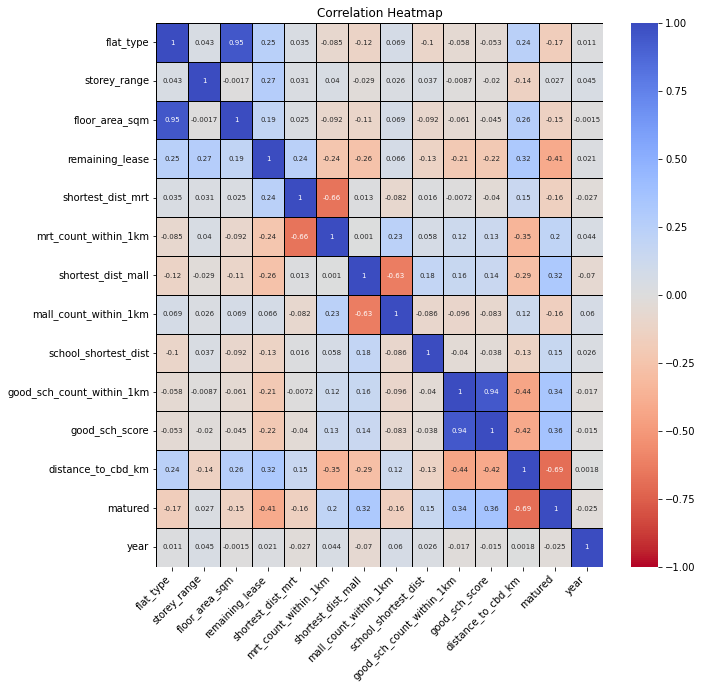

In [ ]:
#Check for collinearity
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(X_train_encoded.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()


In [20]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X_train_encoded):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["features"] = X_train_encoded.columns
    vif["VIF"] = [variance_inflation_factor(X_train_encoded.values, i) for i in range(X_train_encoded.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['mean'] = vif.VIF.mean()

    return(vif)

calc_vif(X_train_encoded.select_dtypes(include=['int64','float64']))

,features,VIF,tolerance,mean
0,flat_type,75.625913,0.013223,15.100733
1,storey_range,2.723615,0.367159,15.100733
2,floor_area_sqm,11.738116,0.085193,15.100733
3,remaining_lease,1.533297,0.652189,15.100733
4,shortest_dist_mrt,1.974522,0.506452,15.100733
5,mrt_count_within_1km,4.882891,0.204797,15.100733
6,shortest_dist_mall,1.954020,0.511766,15.100733
7,mall_count_within_1km,4.618833,0.216505,15.100733
8,school_shortest_dist,1.078815,0.926943,15.100733
9,good_sch_count_within_1km,13.050662,0.076624,15.100733


Since VIF score is still Rather High, we will drop some variables.

1) flat_type is highly correlated with floor_area_sqm. Since floor_area_sqm is more quantifiable, we will drop flat_type.

2) good_sch_score and good_sch_count_within_1km are highly correlated, we will remove the latter.

3) For the same reason, we will drop mall and mrt count within 1km.

4) Lastly drop matured as it is closely correlated to distance from CBD and the latter is more quantifiable

In [21]:
lr_X_train = X_train_encoded.drop(['flat_type','good_sch_count_within_1km','mrt_count_within_1km','mall_count_within_1km','matured',], axis=1)
lr_X_test = X_test_encoded.drop(['flat_type','good_sch_count_within_1km','mrt_count_within_1km','mall_count_within_1km','matured',], axis=1)
calc_vif(lr_X_train.select_dtypes(include=['int64','float64']))
#VIF is now significantly smaller

,features,VIF,tolerance,mean
0,storey_range,2.706759,0.369446,1.650078
1,floor_area_sqm,1.098552,0.910289,1.650078
2,remaining_lease,1.390054,0.719396,1.650078
3,shortest_dist_mrt,1.084196,0.922342,1.650078
4,shortest_dist_mall,1.161884,0.860671,1.650078
5,school_shortest_dist,1.067615,0.936667,1.650078
6,good_sch_score,1.705379,0.586380,1.650078
7,distance_to_cbd_km,1.547983,0.646002,1.650078
8,year,3.088275,0.323805,1.650078


In [22]:
X_train,X_test,y_train,y_test=lr_X_train,lr_X_test,np.log(y_train),np.log(y_test)

lr = LinearRegression()
lin_reg_r2, lin_reg_mae = model_performance(lr)

lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
np.array(lr_importance.sort_values(by = 'Coeff', ascending = False))

R^2 score = 0.886064095922867
Test loss (MAE): 0.08405500124988519


array([['town_MARINE PARADE', 0.4157391145452134],
       ['town_BUKIT TIMAH', 0.31480443126522367],
       ['floor_area_sqm', 0.2378063828602367],
       ['flat_model_DBSS', 0.17611755483353633],
       ['remaining_lease', 0.1397025144959692],
       ['town_BISHAN', 0.13545421263048754],
       ['town_QUEENSTOWN', 0.12095570822702671],
       ['town_BUKIT MERAH', 0.07739101335666583],
       ['town_CLEMENTI', 0.07351502859539887],
       ['flat_model_Simplified', 0.06731899106642929],
       ['town_CENTRAL AREA', 0.06427562299063863],
       ['flat_model_New Generation', 0.050436220093660326],
       ['flat_model_Maisonette', 0.04727517621120321],
       ['town_BEDOK', 0.031030947082537556],
       ['town_SERANGOON', 0.026896095904982358],
       ['flat_model_Premium Apartment', 0.026877724530053715],
       ['storey_range', 0.0248740488748756],
       ['flat_model_Model A2', 0.02271191994218961],
       ['flat_model_Standard', 0.022637698568702524],
       ['town_TOA PAYOH', 0.020476

Linear Regression (K-fold Cross Validation)

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

lr_r2_scores = []
lr_mae_scores = []
lr_feature_importance = []

rf_X = X.drop(['flat_type','good_sch_count_within_1km','mrt_count_within_1km','mall_count_within_1km','matured',], axis=1)

for train_idx, test_idx in kfold.split(X):
    X_train, X_test ,y_train,y_test = rf_X.iloc[train_idx], rf_X.iloc[test_idx], y[train_idx], y[test_idx]
    
    # Scale the features using the StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.log(y_train)
    y_test = np.log(y_test)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    r2_score_value = r2_score(y_test, y_pred)
    lr_r2_scores.append(r2_score_value)
    
    mae_score_value = mean_absolute_error(y_test, y_pred)
    lr_mae_scores.append(mae_score_value)
    
    coef = lr.coef_
    feature_importance = sorted(zip(X.columns, coef), key=lambda x: abs(x[1]), reverse=True)[:5]
    lr_feature_importance.append(feature_importance)

lr_mean_r2_score = sum(lr_r2_scores) / len(lr_r2_scores)
lr_mean_mae_score = sum(lr_mae_scores) / len(lr_mae_scores)

# Print the mean R-squared score and mean MAE for Linear Regression
print("Linear Regression Mean R-squared score:", lr_mean_r2_score)
print("Linear Regression Mean MAE:", lr_mean_mae_score)
print("Top 5 most important features with their associated weights:")
for i, feature_importance in enumerate(lr_feature_importance):
    print("Fold ", i+1, ":", feature_importance)

Linear Regression Mean R-squared score: 0.8861517116574961
Linear Regression Mean MAE: 0.08371008570302282
Top 5 most important features with their associated weights:
Fold  1 : [('storey_range', 0.23780638286023653), ('floor_area_sqm', 0.13970251449596927), ('mall_count_within_1km', -0.08590803288372184), ('flat_type', 0.04711209320716347), ('town_MARINE PARADE', -0.04525394353424437)]
Fold  2 : [('storey_range', 0.23762509387695602), ('floor_area_sqm', 0.13893188135969994), ('mall_count_within_1km', -0.08869970439255886), ('flat_type', 0.047347223976590504), ('remaining_lease', -0.04545072793911288)]
Fold  3 : [('storey_range', 0.23765779266044298), ('floor_area_sqm', 0.1391237416984266), ('mall_count_within_1km', -0.0854789227503679), ('flat_type', 0.04755014138300263), ('town_MARINE PARADE', -0.044958860302787666)]
Fold  4 : [('storey_range', 0.2378795848400108), ('floor_area_sqm', 0.1393356361857543), ('mall_count_within_1km', -0.08749499127505517), ('flat_type', 0.047134236143933

2. Random Forest

In [30]:
# Split target variable from dataset
X = df.drop('normalized_price', axis=1)
y = df['normalized_price']
y = y.reset_index(drop=True)

# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

#Scale Data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.log(y_train)
y_test = np.log(y_test)

rf = RandomForestRegressor()
rf_r2, rf_mae = model_performance(rf)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
rf_importance = pd.DataFrame(list(zip(X_train_df.columns, rf.feature_importances_)), columns=['Features', 'Coeff'])
rf_importance.sort_values(by='Coeff', ascending=False)


R^2 score = 0.9703271260210093
Test loss (MAE): 0.040098972999035004


,Features,Coeff
0,flat_type,0.379234
2,floor_area_sqm,0.188553
11,distance_to_cbd_km,0.159889
3,remaining_lease,0.105474
12,matured,0.036521
13,year,0.033403
4,shortest_dist_mrt,0.020786
1,storey_range,0.018677
6,shortest_dist_mall,0.015063
8,school_shortest_dist,0.006772


Random Forest (K-fold Cross Validation)

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate Linear Regression
rf_r2_scores = []
rf_mae_scores = []
rf_feature_importance = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
  # Scale the features using the StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.log(y_train)
    y_test = np.log(y_test)

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    r2_score_value = r2_score(y_test, y_pred)
    rf_r2_scores.append(r2_score_value)
    
    mae_score_value = mean_absolute_error(y_test, y_pred)
    rf_mae_scores.append(mae_score_value)
    
    feature_importance = sorted(zip(X.columns, rf.feature_importances_), key=lambda x: abs(x[1]), reverse=True)[:5]
    rf_feature_importance.append(feature_importance)


rf_mean_r2_score = sum(rf_r2_scores) / len(rf_r2_scores)
rf_mean_mae_score = sum(rf_mae_scores) / len(rf_mae_scores)

# Print the mean R-squared score and mean MAE for Linear Regression
print("Random Forest Regression Mean R-squared score:", rf_mean_r2_score)
print("Random Forest Regression Mean MAE(test loss):", rf_mean_mae_score)
print("Top 5 most important features with their associated weights:")
for i, feature_importance in enumerate(rf_feature_importance):
    print("Fold ", i+1, ":", feature_importance)

Random Forest Regression Mean R-squared score: 0.9704960492571658
Random Forest Regression Mean MAE(test loss): 0.040181459423127716
Top 5 most important features with their associated weights:
Fold  1 : [('storey_range', 0.23792593549615237), ('floor_area_sqm', 0.13887551152276045), ('mall_count_within_1km', -0.08489781065500232), ('flat_type', 0.04719441414459368), ('town_MARINE PARADE', -0.045278623573902034)]
Fold  2 : [('storey_range', 0.23792593549615237), ('floor_area_sqm', 0.13887551152276045), ('mall_count_within_1km', -0.08489781065500232), ('flat_type', 0.04719441414459368), ('town_MARINE PARADE', -0.045278623573902034)]
Fold  3 : [('storey_range', 0.23792593549615237), ('floor_area_sqm', 0.13887551152276045), ('mall_count_within_1km', -0.08489781065500232), ('flat_type', 0.04719441414459368), ('town_MARINE PARADE', -0.045278623573902034)]
Fold  4 : [('storey_range', 0.23792593549615237), ('floor_area_sqm', 0.13887551152276045), ('mall_count_within_1km', -0.08489781065500232

3. XG Boost

In [35]:
# Split target variable from dataset
X = df.drop('normalized_price', axis=1)
y = df['normalized_price']
y = y.reset_index(drop=True)

# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

#Scale Data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.log(y_train)
y_test = np.log(y_test)

xgb = XGBRegressor()
xgb_r2, xgb_mae = model_performance(xgb)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
xgb_importance = pd.DataFrame(list(zip(X_train_df.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance.sort_values(by = 'Coeff', ascending = False)


R^2 score = 0.9651418998198029
Test loss (MAE): 0.04466974951769271


,Features,Coeff
0,flat_type,0.318409
12,matured,0.193060
2,floor_area_sqm,0.087250
44,flat_model_New Generation,0.067987
11,distance_to_cbd_km,0.035247
28,town_MARINE PARADE,0.031185
39,flat_model_DBSS,0.022950
19,town_BUKIT TIMAH,0.018570
15,town_BISHAN,0.014584
3,remaining_lease,0.014031


XG Boost (K-fold Cross Validation)

In [36]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate Linear Regression
xgb_r2_scores = []
xgb_mae_scores = []
xgb_feature_importance = []

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
  # Scale the features using the StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.log(y_train)
    y_test = np.log(y_test)

    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    
    y_pred = xgb.predict(X_test)
    r2_score_value = r2_score(y_test, y_pred)
    xgb_r2_scores.append(r2_score_value)
    
    mae_score_value = mean_absolute_error(y_test, y_pred)
    xgb_mae_scores.append(mae_score_value)
    
    feature_importance = sorted(zip(X.columns, xgb.feature_importances_), key=lambda x: abs(x[1]), reverse=True)[:5]
    xgb_feature_importance.append(feature_importance)


xgb_mean_r2_score = sum(xgb_r2_scores) / len(xgb_r2_scores)
xgb_mean_mae_score = sum(xgb_mae_scores) / len(xgb_mae_scores)

# Print the mean R-squared score and mean MAE for Linear Regression
print("XG Boost Regression Mean R-squared score:", xgb_mean_r2_score)
print("XG Boost Regression Mean MAE(test loss):", xgb_mean_mae_score)
print("Top 5 most important features with their associated weights:")
for i, feature_importance in enumerate(xgb_feature_importance):
    print("Fold ", i+1, ":", feature_importance)

XG Boost Regression Mean R-squared score: 0.965363006958564
XG Boost Regression Mean MAE(test loss): 0.04481723151622119
Top 5 most important features with their associated weights:
Fold  1 : [('flat_type', 0.30534554), ('matured', 0.22257614), ('floor_area_sqm', 0.08877616), ('distance_to_cbd_km', 0.036274187), ('flat_model_DBSS', 0.029025175)]
Fold  2 : [('flat_type', 0.31744012), ('matured', 0.21362858), ('floor_area_sqm', 0.08204163), ('flat_model_New Generation', 0.044662476), ('distance_to_cbd_km', 0.034578856)]
Fold  3 : [('flat_type', 0.3299471), ('matured', 0.18967034), ('floor_area_sqm', 0.08620176), ('distance_to_cbd_km', 0.03758828), ('town_BISHAN', 0.03266622)]
Fold  4 : [('flat_type', 0.31646165), ('matured', 0.21296373), ('floor_area_sqm', 0.09062832), ('distance_to_cbd_km', 0.04240022), ('town_MARINE PARADE', 0.034260992)]
Fold  5 : [('flat_type', 0.3058786), ('matured', 0.18715785), ('floor_area_sqm', 0.08927211), ('distance_to_cbd_km', 0.038328297), ('flat_model_DBSS'